[Docling documentation](https://ds4sd.github.io/docling/)   
[Docling technical report](https://arxiv.org/abs/2408.09869)   
[RAG with LlamaIndex](https://ds4sd.github.io/docling/examples/rag_llamaindex/)

## Setup 

In [2]:
import logging
import time
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

In [6]:
import torch

# Check if GPU or MPS is available
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f"CUDA GPU is enabled: {torch.cuda.get_device_name(0)}")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("MPS GPU is enabled.")
# else:
#     raise EnvironmentError(
#         "No GPU or MPS device found. Please check your environment and ensure GPU or MPS support is configured."
#     )

## Download data

In [5]:
!mkdir data

!curl "https://www.kone.es/Images/KONE%20Sustainability_tcm117-105566.pdf" -O data/kone-sustainability-report-2023.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 22 8609k   22 1947k    0     0  1422k      0  0:00:06  0:00:01  0:00:05 1424k
 50 8609k   50 4381k    0     0  1849k      0  0:00:04  0:00:02  0:00:02 1851k
 78 8609k   78 6742k    0     0  2001k      0  0:00:04  0:00:03  0:00:01 2002k
100 8609k  100 8609k    0     0  2037k      0  0:00:04  0:00:04 --:--:-- 2038k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:-

In [3]:
SOURCE = "./data/kone-sustainability-report-2023.pdf"
FIRST_10_PAGES = "./data/report_10_page.pdf"

_log = logging.getLogger(__name__)

In [4]:
from PyPDF2 import PdfReader, PdfWriter

reader = PdfReader(SOURCE)
writer = PdfWriter()

# Extract the first 10 pages
for page_num in range(min(10, len(reader.pages))):
    writer.add_page(reader.pages[page_num])

# Save the extracted pages to a new PDF
with open(FIRST_10_PAGES, 'wb') as output_pdf:
    writer.write(output_pdf)

In [10]:
from pathlib import Path
from PyPDF2 import PdfReader, PdfWriter

# Define the source and output file paths
SOURCE = SOURCE
OUTPUT = Path("./data/page_25.pdf")

# Read the PDF file
reader = PdfReader(SOURCE)
writer = PdfWriter()

# Ensure the requested page exists in the document
if len(reader.pages) >= 24:
    # Add page 24 (index 23 since it's 0-based)
    writer.add_page(reader.pages[24])
else:
    print("The PDF does not contain 24 pages.")

# Save the extracted page to a new PDF file
with OUTPUT.open('wb') as output_pdf:
    writer.write(output_pdf)

print(f"Page 24 has been saved to {OUTPUT}")

Page 24 has been saved to data\page_25.pdf


### Convert pdf to markdown (default options)

In [11]:
from docling.document_converter import DocumentConverter

#### Parsing first 10 pages

In [12]:
converter = DocumentConverter()
result = converter.convert(FIRST_10_PAGES)
#print(result.document.export_to_markdown)
# Save to markdown

output_dir = Path("parsed-doc")
output_dir.mkdir(parents=True, exist_ok=True)


doc_filename = Path(FIRST_10_PAGES).stem


md_filename = output_dir / f"{doc_filename}.md"
result.document.save_as_markdown(md_filename)

#### Parsing just page 24

In [13]:
# Initialize the DocumentConverter
converter = DocumentConverter()

# Convert the document
#result = converter.convert(FIRST_10_PAGES)
result = converter.convert("./data/page_25.pdf")

# Save markdown with embedded pictures
doc_filename = Path(".data/page_25.pdf").stem
md_filename = output_dir / f"{doc_filename}.md"
result.document.save_as_markdown(md_filename)

##### Decoding the image from markdown

In [14]:
# The encoded string
encoded_string = "/uni0043/uni0061/uni0072/uni0062/uni006F/uni006E/uni0020/uni0066/uni006F/uni006F/uni0074/uni0070/uni0072/uni0069/uni006E/uni0074/uni0020/uni0028/uni006B/uni0067/uni0043/uni004F/uniE0C0/uni0065/uni002F/uni0079/uni0065/uni0061/uni0072/uni0029"
# Decode the string
def decode_unicode_string(encoded):
    # Split the string by '/' and filter out empty parts
    parts = [part for part in encoded.split("/") if part.startswith("uni")]
    # Convert each Unicode point to a character
    decoded = "".join([chr(int(part[3:], 16)) for part in parts])
    return decoded

# Get the decoded string
decoded_string = decode_unicode_string(encoded_string)
print(decoded_string)

Carbon footprint (kgCOe/year)


### Convert pdf to markdown (advanced options)
- https://ds4sd.github.io/docling/usage/
- https://ds4sd.github.io/docling/installation/

In [110]:
import time
from docling.datamodel.base_models import InputFormat
from docling_core.types.doc import ImageRefMode
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode, EasyOcrOptions, TesseractOcrOptions, OcrMacOptions
from docling.datamodel.settings import settings

output_dir = Path("parsed-doc-advanced")

IMAGE_RESOLUTION_SCALE = 2.0

# Define pipeline options for PDF processing
pipeline_options = PdfPipelineOptions(
    do_table_structure=True,  # Enable table structure detection
    do_ocr=True,  # Enable OCR
    # full page ocr and language selection
    #ocr_options=EasyOcrOptions(force_full_page_ocr=True, lang=["en"]),  # Use EasyOCR for OCR
    ocr_options=TesseractOcrOptions(force_full_page_ocr=True, lang=["eng"]),  # Uncomment to use Tesseract for OCR
    #ocr_options = OcrMacOptions(force_full_page_ocr=True, lang=['en-US']),
    table_structure_options=dict(
        do_cell_matching=False,  # Use text cells predicted from table structure model
        mode=TableFormerMode.ACCURATE  # Use more accurate TableFormer model
    ),
    generate_page_images=True,  # Enable page image generation
    generate_picture_images=True,  # Enable picture image generation
    images_scale=IMAGE_RESOLUTION_SCALE, # Set image resolution scale (scale=1 corresponds to a standard 72 DPI image)
)

# Initialize the DocumentConverter with the specified pipeline options
doc_converter_global = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

In [111]:
# Enable the profiling to measure the time spent
settings.debug.profile_pipeline_timings = True

# Convert the document
#result = doc_converter_global.convert(FIRST_10_PAGES)
#result = doc_converter_global.convert(SOURCE)
result = doc_converter_global.convert("./data/page_25.pdf")

output_dir.mkdir(parents=True, exist_ok=True)
#doc_filename = Path(FIRST_10_PAGES).stem
#doc_filename = Path(FIRST_10_PAGES).stem
doc_filename = Path("./data/page_25.pdf").stem

# Save markdown with embedded pictures
# md_filename = output_dir / f"{doc_filename}.md"
md_filename = output_dir / f"{doc_filename}-with-images.md"
# result.document.save_as_markdown(md_filename) # just shows there is image at this point, <!-- image -->
# result.document.save_as_markdown(md_filename, image_mode=ImageRefMode.EMBEDDED) # image is embedded with base64
result.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED) #artifacts folder is created with this

_log.info(f"Markdown content has been saved to {md_filename}")

### Chunking

In [20]:
from docling.document_converter import DocumentConverter
from docling.chunking import HybridChunker

#conv_res = DocumentConverter().convert(FIRST_10_PAGES)
#doc = conv_res.document

chunker = HybridChunker(tokenizer="BAAI/bge-small-en-v1.5")  # set tokenizer as needed
chunk_iter = chunker.chunk(result.document)

# Convert the iterator to a list to count the chunks
chunks = list(chunk_iter)
num_chunks = len(chunks)

# Print the number of chunks
print(f"The document has been divided into {num_chunks} chunks.")

The document has been divided into 1 chunks.


DoclingDocument(schema_name='DoclingDocument', version='1.3.0', name='page_25', origin=DocumentOrigin(mimetype='application/pdf', binary_hash=705762892992442654, filename='page_25.pdf', uri=None), furniture=GroupItem(self_ref='#/furniture', parent=None, children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>), body=GroupItem(self_ref='#/body', parent=None, children=[RefItem(cref='#/texts/0'), RefItem(cref='#/texts/1'), RefItem(cref='#/texts/2'), RefItem(cref='#/texts/3'), RefItem(cref='#/texts/4'), RefItem(cref='#/texts/5'), RefItem(cref='#/texts/6'), RefItem(cref='#/texts/7'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/pictures/0'), RefItem(cref='#/texts/22'), RefItem(cref='#/texts/23'), RefItem(cref='#/pictures/1'), RefItem(cref='#/texts/24'), RefItem(cref='#/groups/0'), RefItem(cref='#/texts/27'), RefItem(cref='#/groups/1')], content_layer=<ContentLayer.BODY: 'body'>, name='_root_', lab
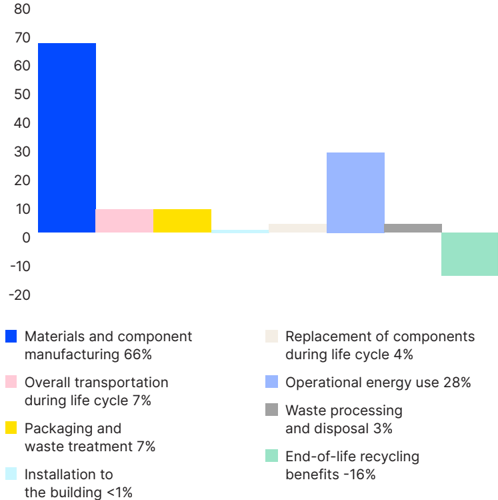
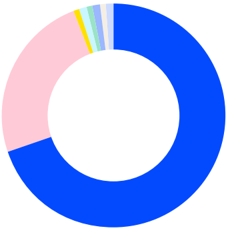
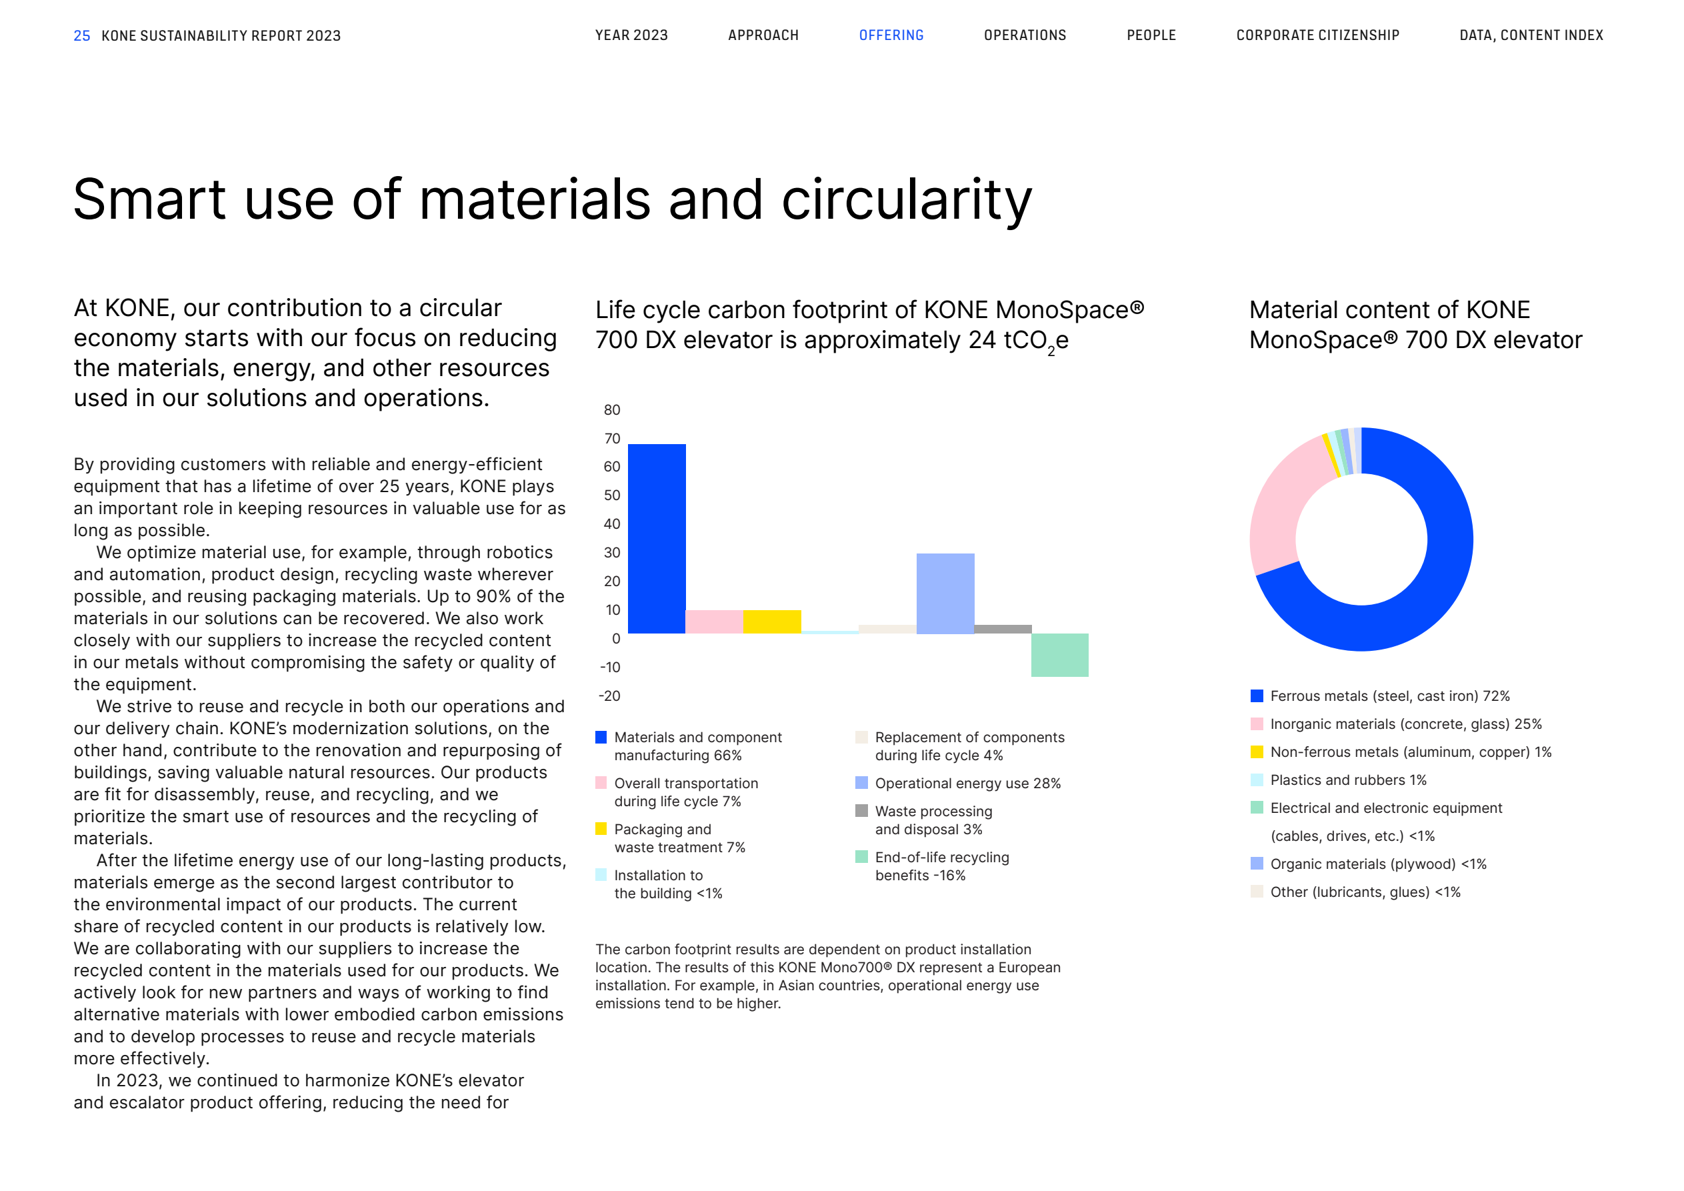

In [112]:
result.document

In [22]:
print(chunks[0].text)

At KONE, our contrioution to a circular economy starts with our focus on reducing the materials, energy, and other resources used In our solutions and operations.
Life cycle carbon footprint of KONE MonoSpace® /00 DX elevator Is approximately 24 tCO,e
By providing customers with reliable and energy-efficient equipment that has a lifetime of over 25 years, KONE plays an important role in keeping resources in valuable use for as long as possible.
We optimize material use, for example, through robotics and automation, product design, recycling waste wherever possible, and reusing packaging materials. Up to 90% of the materials in our solutions can be recovered. We also work closely with our suppliers to increase the recycied content in our metals without compromising the safety or quality of the equipment.
We strive to reuse and recycle in both our operations and our delivery chain. KONE's modernization solutions, on the other hand, contribute to the renovation and repurposing of building

### [FAQs](https://ds4sd.github.io/docling/faq/)

### [Command Line Syntaxes](https://ds4sd.github.io/docling/v2/#cli)

In [ ]:
!uv pip show tesserocr

In [ ]:
!uv run docling data/page_24.pdf

In [ ]:
!uv run docling images/caltrain_schedule.png

In [ ]:
!uv run docling https://www.kone.es/Images/KONE%20Sustainability_tcm117-105566.pdf

###  View the base64 encoded image via this [link](https://codebeautify.org/base64-to-image-converter)

In [23]:
import base64
from io import BytesIO
from PIL import Image

# Base64 string (trim "data:image/png;base64," if needed)
base64_string = "iVBORw0KGgoAAAANSUhEUgAAADUAAAA2CAIAAADoEEaJAAAKdElEQVR4nM1ZS4gdRReuqu7qrn5UG2cYyMigKBoRH4H8ZGM2gqioKMGNCv7RSSKiRFESs3FwERcusoigSx/gQhQERdxlEwIZ8IGQLMSAkZBMTDTxQb/7VleXi8/b07mvuTOBn/8sLvf2rcdXX5065zvV1BhD/o+N/Y/nM8asixF7Y3MQQrTWhJCmadrPgYkppZRSQghjjBBiWRZ+rss2gq8sy7quT5w4UVXVjz/+qJQ6c+aM1vqvv/4yxgC3EMKyrBtvvNG27TvuuMN13R07dnDOb7jhhnWhXAc+zG2MSdO0rus4jquqiuNYKRXHsdY6SZIWX6/XsywrjmPbtuM4dl03SRLOeVmWjDHXdQkh0wCdFp9Sqq7r48ePZ1n21ltv5Xl+/vx5Y8yE/SWE2Lbd/XQc58knnwzD8OWXXxZCbNq0qfWBjeODR+d5Ds7yPE+SJM/zoijW7AvcdV3jp+M4cRwbY5IkUUr5vs8Ycxxnwgh0wmkCPRcvXszzfGlpKcuy5eXluq7zPJ/yGIK59jxRSh3HoZTOz88LIQ4ePBgEwc6dOznnaDPM5ST+gC/LMnCGL1prsHLVKjvj4vtI9MaYXq9HKQV/cRw3TVNVlTHGtu2RGz2Wv6ZpVlZW0jR9/vnn0zT96aefmqaB73dxNE1DKfU8jzEmpaSUgjPMmqYpMJF+POr2lVK6rrt//34p5bPPPus4jmVZpB+PJvEH5tK+ZVlW1zWgDMzheR6lFJ4UBAGllHOOf03f0L4sy/Y7vpRliVkIIUopSinwrcGfMebSpUtpmj766KNpmv7+++/tOYUh0m7atMnzvEOHDgkhoiiilDZNwxi7/fbbm6Y5evSoMWbr1q1N03z++edFUXz66ae9Xk8pRfrnBisJgkAIcfjwYSnlI488MrDRo/kry7IoCjDXNM1IH/A8TwjRDRCcc8ZY4Ae60aZjlmWxvg2PU1UVISRNU0ppXdeMsS6LI/irqmr//v1Jknz22WdKqZGnwfO8d999lzG2tLRUlmWWZZzzF198MQzDvXv2VlW17T/b8jzHZHfeeSdj7MqVK1rrs2fPtgPCU4FpZmYmCIJPPvkkDMO77rqrXckgf1rruq7hdpODCDyvrmulVK/Xgw+0c9d1Xdc1yMMTxti40YwxRVEwxvI8H3DBq/BprZeXl+M4/uKLLxCQRw6HTDAzM2NZ1r333gtwnPPbbrtNCNFTPd3oBx98sCxLkD0/P08IOX36dF3XXf7a8RH/q6p65513oih6//33sfhBfGiX5zmy2TjmOOecc9u2bdsOwxAub9s2KMTCwjDknMM7gyAwxgRBgEOKoz1MIWa3bRseD3yrTauqyrLsqaeeSpLk+++/727WAHmPP/64lPK9997zPA+xjVJaluWhQ4fyPP/mm28cx/noo4+CIJibm6OUYmf//PPPJEnuv//+NE2R5Yajie/7YRguLy9LKWdmZiilq/wh/BZFsWZibfmzLMvzPDxEfMEIWmvXdYUQ7TZhbq01Y2yCIIDXlmWJ0EPa/UW2SJLkzJkzWZZBR40cglIaRVEURfjZ5k1jjBBCay2EcBwHC+h2vO6662zb9jxPKZVl2cjxlVJ5nsMLEVlXhwB2rXU3EY2DOJID13XrurYsCwF8oM2aUgqGjN9u/Sp/58+fj+M4TdOiKNZbNBljXNc9cOBAURSXL18mhMzOznY3d0oDQV9//XUURW+//bbruqv8KaWUUuutX7rmuq4xxvd9MjVbI62LZJW/kydPQqZvbFBCCOfcsqylpaUW63ohIm0gSv/xxx9KqUH+NgwOhtR3jYOAOQQ4u3106dIlCMZrAUcpvf7668l0tc+wtWmXUpplGWNslb9r8bwBlNc+COnjGcS3sdHH9RqoKjD+lFMM4lvvieuGoXE+B29BQvI8b13OAzx2+2Nubg5l8zQ9y7JcXFwkhMzNzXmed/jw4eG+TdOcO3cuy7InnnjCGPPxxx/D61vpP0xHK0q01r7vB0Gwyh/0yDT4MA1yICLq5MYQYGg/pZdDVayeD8bYtm3bcB0xOcog0/i+v2fPHmRxyPphPhhjmzdv7vV6L730ktaac15VFWoGYB1JByJUEASzs7NSytUWUCXj9FnXIJiBwHEcKLaB6q47H5RLWZZVVY2TbV0DEiidVf5uuummJEmklIyxcfqCEKK1PnbsGOc8DMMwDN98803Xdc+ePds2QEfQCZmzY8eOoiheeeWVPM///vtvrfWw8oNZlsU5f+ihh6Iocl3XsqxB/0OtNXl9uKkoisKyLOidNE1bVrr4sIPYkzzPJyy7NUopVv4vqpa/hYWFNE0XFhagAifsAnz82LFjQoh77rmHEHLkyJGqqob975ZbbvE8b3FxsWmaCxcuoESfEMUgeA8ePAj+SLf+QC0ohJgmC+OeAC6P6gse2W0AjgkhuLLBeZzsfNhDIYQQ4t8n7X+u61JK9+3blyTJq6++OkHl27bt+/6RI0c450ePHq2qasuWLQMTtyRZlnXlyhVCyPbt28uy/Pbbb+u67lLY+oNt29u3b4+iaHZ21vf9EfUbzlrTNFjHuBIOzAVBYFkWVDdjjBJK6FVDkf6dEMZB+wn1B2YHsrbNVfnXtu0HHnigKIr77rsvjuPjx4+jxgYNmM9xnJ07dwZBMD8/jwxRliWjjFgE+P6tCykl/Zua7777TgjxxhtvNE3z3HPPZVn222+/mf5NMMZ3XdfzvL179+JSawS+lpu6roMgwCEdXiLuqXzfr6oKlw11XTPKCBmBD6eh1+vBuRF7h/MNpRT1Hvi76q/hA980zenTp5Mkwf0VTgDpn3Hf9z/44ANK6QsvvICQMdAd4QmfLUOO4zzzzDNCiJtvvrnX67322mvt/YTjOEKIpaUlKeWu/+5yHMfmnahHRhkiPup+XBG1SokxhlmzLEOpO9C39XfSeUcCvYmf3W2hlDqO4zgOYt6wBhidyhARfvjhhzRN9+3bl2XZysoKIWTz5s2WZUVRZIz5+eefB5JV66Mj1yyltCzr1ltvNcacOnWqaRpki127dkkpX3/9dSFEEAQDvUbzh90JwxDRHLSRzo00vgyIkS5zw4Y3Iq1qhM+5riullFKipB/uNZq/dneapvnll1/SNN29e3eWZefOnWv3ergj+MPzcXEYp4RzLoQ4cOCAlHJxcRHgRsadSYIPER+pEHffrutqraHnJnScYMCHO10w57ruSOZga7z/IP09vXz5slLqyy+/zPP8ww8/LMtyZWWlTabdGAkb9kLbtjnnDz/8sO/7u3fv9jxv69at7fuZcUF7bcHcxjylVBRFlmVJKbFB7V5Db3aFT7cyaiMf51xKGQSBlNLzPMdx1tRKa0jRgfnau2yl1FdffVUUxYkTJ5RSv/76KxRo2x55bGZmxrbtu+++Wwjx9NNPu667sLDAGIO3dcFtnL9uf+wF7kyjKAIfSikpJRQ86ew19Klt21EUwduQxNZVJU7L37Ah+uMT1zlgFwMizELD4Z3blMXXgNnTvIacxroxkly9X10VMy42jRU1jz32WPe/9d6/oDKH53X9CZjwhPbf1LX/jjsWw7HzHz0JVD+re/zvAAAAAElFTkSuQmCC"

# Decode the Base64 string
image_data = base64.b64decode(base64_string)

# Convert to an image and display
image = Image.open(BytesIO(image_data))
image.show()

# Optionally save the image
with open("decoded_image.png", "wb") as file:
    file.write(image_data)

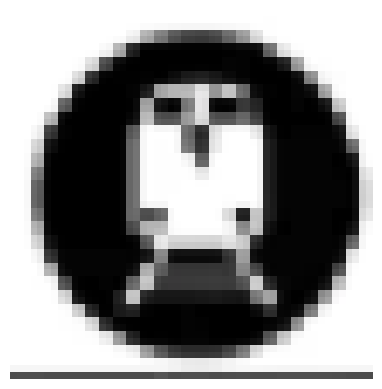

In [24]:
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Base64 string (trim "data:image/png;base64," if needed)
base64_string = "iVBORw0KGgoAAAANSUhEUgAAADUAAAA2CAIAAADoEEaJAAAKdElEQVR4nM1ZS4gdRReuqu7qrn5UG2cYyMigKBoRH4H8ZGM2gqioKMGNCv7RSSKiRFESs3FwERcusoigSx/gQhQERdxlEwIZ8IGQLMSAkZBMTDTxQb/7VleXi8/b07mvuTOBn/8sLvf2rcdXX5065zvV1BhD/o+N/Y/nM8asixF7Y3MQQrTWhJCmadrPgYkppZRSQghjjBBiWRZ+rss2gq8sy7quT5w4UVXVjz/+qJQ6c+aM1vqvv/4yxgC3EMKyrBtvvNG27TvuuMN13R07dnDOb7jhhnWhXAc+zG2MSdO0rus4jquqiuNYKRXHsdY6SZIWX6/XsywrjmPbtuM4dl03SRLOeVmWjDHXdQkh0wCdFp9Sqq7r48ePZ1n21ltv5Xl+/vx5Y8yE/SWE2Lbd/XQc58knnwzD8OWXXxZCbNq0qfWBjeODR+d5Ds7yPE+SJM/zoijW7AvcdV3jp+M4cRwbY5IkUUr5vs8Ycxxnwgh0wmkCPRcvXszzfGlpKcuy5eXluq7zPJ/yGIK59jxRSh3HoZTOz88LIQ4ePBgEwc6dOznnaDPM5ST+gC/LMnCGL1prsHLVKjvj4vtI9MaYXq9HKQV/cRw3TVNVlTHGtu2RGz2Wv6ZpVlZW0jR9/vnn0zT96aefmqaB73dxNE1DKfU8jzEmpaSUgjPMmqYpMJF+POr2lVK6rrt//34p5bPPPus4jmVZpB+PJvEH5tK+ZVlW1zWgDMzheR6lFJ4UBAGllHOOf03f0L4sy/Y7vpRliVkIIUopSinwrcGfMebSpUtpmj766KNpmv7+++/tOYUh0m7atMnzvEOHDgkhoiiilDZNwxi7/fbbm6Y5evSoMWbr1q1N03z++edFUXz66ae9Xk8pRfrnBisJgkAIcfjwYSnlI488MrDRo/kry7IoCjDXNM1IH/A8TwjRDRCcc8ZY4Ae60aZjlmWxvg2PU1UVISRNU0ppXdeMsS6LI/irqmr//v1Jknz22WdKqZGnwfO8d999lzG2tLRUlmWWZZzzF198MQzDvXv2VlW17T/b8jzHZHfeeSdj7MqVK1rrs2fPtgPCU4FpZmYmCIJPPvkkDMO77rqrXckgf1rruq7hdpODCDyvrmulVK/Xgw+0c9d1Xdc1yMMTxti40YwxRVEwxvI8H3DBq/BprZeXl+M4/uKLLxCQRw6HTDAzM2NZ1r333gtwnPPbbrtNCNFTPd3oBx98sCxLkD0/P08IOX36dF3XXf7a8RH/q6p65513oih6//33sfhBfGiX5zmy2TjmOOecc9u2bdsOwxAub9s2KMTCwjDknMM7gyAwxgRBgEOKoz1MIWa3bRseD3yrTauqyrLsqaeeSpLk+++/727WAHmPP/64lPK9997zPA+xjVJaluWhQ4fyPP/mm28cx/noo4+CIJibm6OUYmf//PPPJEnuv//+NE2R5Yajie/7YRguLy9LKWdmZiilq/wh/BZFsWZibfmzLMvzPDxEfMEIWmvXdYUQ7TZhbq01Y2yCIIDXlmWJ0EPa/UW2SJLkzJkzWZZBR40cglIaRVEURfjZ5k1jjBBCay2EcBwHC+h2vO6662zb9jxPKZVl2cjxlVJ5nsMLEVlXhwB2rXU3EY2DOJID13XrurYsCwF8oM2aUgqGjN9u/Sp/58+fj+M4TdOiKNZbNBljXNc9cOBAURSXL18mhMzOznY3d0oDQV9//XUURW+//bbruqv8KaWUUuutX7rmuq4xxvd9MjVbI62LZJW/kydPQqZvbFBCCOfcsqylpaUW63ohIm0gSv/xxx9KqUH+NgwOhtR3jYOAOQQ4u3106dIlCMZrAUcpvf7668l0tc+wtWmXUpplGWNslb9r8bwBlNc+COnjGcS3sdHH9RqoKjD+lFMM4lvvieuGoXE+B29BQvI8b13OAzx2+2Nubg5l8zQ9y7JcXFwkhMzNzXmed/jw4eG+TdOcO3cuy7InnnjCGPPxxx/D61vpP0xHK0q01r7vB0Gwyh/0yDT4MA1yICLq5MYQYGg/pZdDVayeD8bYtm3bcB0xOcog0/i+v2fPHmRxyPphPhhjmzdv7vV6L730ktaac15VFWoGYB1JByJUEASzs7NSytUWUCXj9FnXIJiBwHEcKLaB6q47H5RLWZZVVY2TbV0DEiidVf5uuummJEmklIyxcfqCEKK1PnbsGOc8DMMwDN98803Xdc+ePds2QEfQCZmzY8eOoiheeeWVPM///vtvrfWw8oNZlsU5f+ihh6Iocl3XsqxB/0OtNXl9uKkoisKyLOidNE1bVrr4sIPYkzzPJyy7NUopVv4vqpa/hYWFNE0XFhagAifsAnz82LFjQoh77rmHEHLkyJGqqob975ZbbvE8b3FxsWmaCxcuoESfEMUgeA8ePAj+SLf+QC0ohJgmC+OeAC6P6gse2W0AjgkhuLLBeZzsfNhDIYQQ4t8n7X+u61JK9+3blyTJq6++OkHl27bt+/6RI0c450ePHq2qasuWLQMTtyRZlnXlyhVCyPbt28uy/Pbbb+u67lLY+oNt29u3b4+iaHZ21vf9EfUbzlrTNFjHuBIOzAVBYFkWVDdjjBJK6FVDkf6dEMZB+wn1B2YHsrbNVfnXtu0HHnigKIr77rsvjuPjx4+jxgYNmM9xnJ07dwZBMD8/jwxRliWjjFgE+P6tCykl/Zua7777TgjxxhtvNE3z3HPPZVn222+/mf5NMMZ3XdfzvL179+JSawS+lpu6roMgwCEdXiLuqXzfr6oKlw11XTPKCBmBD6eh1+vBuRF7h/MNpRT1Hvi76q/hA980zenTp5Mkwf0VTgDpn3Hf9z/44ANK6QsvvICQMdAd4QmfLUOO4zzzzDNCiJtvvrnX67322mvt/YTjOEKIpaUlKeWu/+5yHMfmnahHRhkiPup+XBG1SokxhlmzLEOpO9C39XfSeUcCvYmf3W2hlDqO4zgOYt6wBhidyhARfvjhhzRN9+3bl2XZysoKIWTz5s2WZUVRZIz5+eefB5JV66Mj1yyltCzr1ltvNcacOnWqaRpki127dkkpX3/9dSFEEAQDvUbzh90JwxDRHLSRzo00vgyIkS5zw4Y3Iq1qhM+5riullFKipB/uNZq/dneapvnll1/SNN29e3eWZefOnWv3ergj+MPzcXEYp4RzLoQ4cOCAlHJxcRHgRsadSYIPER+pEHffrutqraHnJnScYMCHO10w57ruSOZga7z/IP09vXz5slLqyy+/zPP8ww8/LMtyZWWlTabdGAkb9kLbtjnnDz/8sO/7u3fv9jxv69at7fuZcUF7bcHcxjylVBRFlmVJKbFB7V5Db3aFT7cyaiMf51xKGQSBlNLzPMdx1tRKa0jRgfnau2yl1FdffVUUxYkTJ5RSv/76KxRo2x55bGZmxrbtu+++Wwjx9NNPu667sLDAGIO3dcFtnL9uf+wF7kyjKAIfSikpJRQ86ew19Klt21EUwduQxNZVJU7L37Ah+uMT1zlgFwMizELD4Z3blMXXgNnTvIacxroxkly9X10VMy42jRU1jz32WPe/9d6/oDKH53X9CZjwhPbf1LX/jjsWw7HzHz0JVD+re/zvAAAAAElFTkSuQmCC"

# Decode the Base64 string
image_data = base64.b64decode(base64_string)

# Convert to an image and display
image = Image.open(BytesIO(image_data))

# Display the image inline
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

### Scanned pdf

In [ ]:
!uv run docling data/scanned-document.pdf 

In [25]:
result = doc_converter_global.convert("./data/scanned-document.pdf")

output_dir.mkdir(parents=True, exist_ok=True)
#doc_filename = Path(FIRST_10_PAGES).stem
#doc_filename = Path(FIRST_10_PAGES).stem
doc_filename = Path("./data/scanned-document.pdf").stem

# Save markdown with embedded pictures
md_filename = output_dir / f"{doc_filename}.md"
result.document.save_as_markdown(md_filename)

### Figure Export

In [27]:
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

In [28]:

input_doc_path = FIRST_10_PAGES
output_dir = Path("scratch_image")

# Important: For operating with page images, we must keep them, otherwise the DocumentConverter
# will destroy them for cleaning up memory.
# This is done by setting PdfPipelineOptions.images_scale, which also defines the scale of images.
# scale=1 correspond of a standard 72 DPI image
# The PdfPipelineOptions.generate_* are the selectors for the document elements which will be enriched
# with the image field
pipeline_options = PdfPipelineOptions()
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

start_time = time.time()

conv_res = doc_converter.convert(input_doc_path)

output_dir.mkdir(parents=True, exist_ok=True)
doc_filename = conv_res.input.file.stem

# Save page images
for page_no, page in conv_res.document.pages.items():
    page_no = page.page_no
    page_image_filename = output_dir / f"{doc_filename}-{page_no}.png"
    with page_image_filename.open("wb") as fp:
        page.image.pil_image.save(fp, format="PNG")

# Save images of figures and tables
table_counter = 0
picture_counter = 0
for element, _level in conv_res.document.iterate_items():
    if isinstance(element, TableItem):
        table_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-table-{table_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

    if isinstance(element, PictureItem):
        picture_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-picture-{picture_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

# Save markdown with embedded pictures
md_filename = output_dir / f"{doc_filename}-with-images.md"
conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.EMBEDDED)

# Save markdown with externally referenced pictures
md_filename = output_dir / f"{doc_filename}-with-image-refs.md"
conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

# Save HTML with externally referenced pictures
html_filename = output_dir / f"{doc_filename}-with-image-refs.html"
conv_res.document.save_as_html(html_filename, image_mode=ImageRefMode.REFERENCED)

end_time = time.time() - start_time

_log.info(f"Document converted and figures exported in {end_time:.2f} seconds.")

### Table Export

In [26]:
import pandas as pd
from docling.document_converter import DocumentConverter

In [ ]:
def main():
    logging.basicConfig(level=logging.INFO)

    input_doc_path = FIRST_10_PAGES
    output_dir = Path("scratch_table")

    doc_converter = DocumentConverter()

    start_time = time.time()

    conv_res = doc_converter.convert(input_doc_path)

    output_dir.mkdir(parents=True, exist_ok=True)

    doc_filename = conv_res.input.file.stem

    # Export tables
    for table_ix, table in enumerate(conv_res.document.tables):
        table_df: pd.DataFrame = table.export_to_dataframe()

        # Save the table as csv
        element_csv_filename = output_dir / f"{doc_filename}-table-{table_ix+1}.csv"
        _log.info(f"Saving CSV table to {element_csv_filename}")
        table_df.to_csv(element_csv_filename)

        # Save the table as html
        element_html_filename = output_dir / f"{doc_filename}-table-{table_ix+1}.html"
        _log.info(f"Saving HTML table to {element_html_filename}")
        with element_html_filename.open("w") as fp:
            fp.write(table.export_to_html())

    end_time = time.time() - start_time

    _log.info(f"Document converted and tables exported in {end_time:.2f} seconds.")
    
if __name__ == "__main__":
    main()

## Setup with LlamaIndex

In [43]:
! pip install llama-index-llms-groq


   ---------------------------------------- 2/2 [llama-index-llms-groq]



In [45]:
# setup llm
from llama_index.llms.ollama import Ollama
from llama_index.llms.groq import Groq

# llm = Ollama(model="llama3:latest", request_timeout=120.0)
llm = Groq(model="llama3-70b-8192", api_key="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")

In [30]:
#setup embedding model
# https://docs.llamaindex.ai/en/stable/examples/embeddings/ollama_embedding/
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


#embed_model = OllamaEmbedding(model_name="nomic-embed-text:latest")
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

In [33]:
print(embed_model)

model_name='BAAI/bge-small-en-v1.5' embed_batch_size=10 callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000021522B88650> num_workers=None max_length=512 normalize=True query_instruction=None text_instruction=None cache_folder=None show_progress_bar=False


In [34]:
print(llm)

callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x0000021522B88650> system_prompt=None messages_to_prompt=<function messages_to_prompt at 0x0000021507BD2660> completion_to_prompt=<function default_completion_to_prompt at 0x0000021530EE7BA0> output_parser=None pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'> query_wrapper_prompt=None base_url='http://localhost:11434' model='llama3:latest' temperature=0.75 context_window=3900 request_timeout=120.0 prompt_key='prompt' json_mode=False additional_kwargs={} is_function_calling_model=True keep_alive=None


## Define Global Settings Configuration
In LlamaIndex, you can define global settings so you don't have to pass the LLM / embedding model objects everywhere.

In [46]:

from llama_index.core import Settings

Settings.llm = llm
Settings.embed_model = embed_model

## Retrieve and Generate

In [35]:
from llama_index.core import StorageContext, VectorStoreIndex
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.readers.docling import DoclingReader

#reader = DoclingReader()
reader = DoclingReader(DocumentConverter = doc_converter_global)
node_parser = MarkdownNodeParser()

In [36]:
documents = reader.load_data(SOURCE)

In [ ]:
len(documents)

1

In [105]:
documents

[Document(id_='951b012b-a2fe-4b86-8c3a-c80041d83e6c', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text="0 NIE\n\nSustainability Report 2023\n\nwww.kone.com\n\nDedicated to People Flow\n\nKONE's elevators and escalators move\n\n## &gt;1 BILLION\n\npeople every day\n\nClose to\n\n600,000\n\ncustomers\n\nOperations in\n\n&gt;60 countries\n\n~30,000\n\nsuppliers\n\n## &gt;1,600,000\n\nequipment in KONE's maintenance base\n\n## &gt;60,000\n\nemployees\n\nAuthorized distributors and agents in close to\n\n100\n\ncountries\n\nSales\n\n## MEUR 10,952\n\n## Contents\n\n| Sustainability highlights 2023 . . . . . . . . . . . . . . . . . . . . .                                                       | . 3   |\n|-------------------------------------------------------------------------------------------------------------

In [36]:
#node_parser.get_nodes_from_documents??

In [39]:
# Extract nodes from documents
nodes = node_parser.get_nodes_from_documents(documents)

# Display the number of nodes extracted
print(f"Number of nodes extracted: {len(nodes)}")


# Iterate over each node to print its text and metadata
for index, node in enumerate(nodes, start=1):
    print(f"\nNode {index}:")
    print("Text:")
    print(node.text)
    print("Metadata:")
    print(node.metadata)


Number of nodes extracted: 201

Node 1:
Text:
0 NIE

Sustainability Report 2023

www.kone.com

Dedicated to People Flow

KONE's elevators and escalators move
Metadata:
{'header_path': '/'}

Node 2:
Text:
## &gt;1 BILLION

people every day

Close to

600,000

customers

Operations in

&gt;60 countries

~30,000

suppliers
Metadata:
{'header_path': '/'}

Node 3:
Text:
## &gt;1,600,000

equipment in KONE's maintenance base
Metadata:
{'header_path': '/'}

Node 4:
Text:
## &gt;60,000

employees

Authorized distributors and agents in close to

100

countries

Sales
Metadata:
{'header_path': '/'}

Node 5:
Text:
## MEUR 10,952
Metadata:
{'header_path': '/'}

Node 6:
Text:
## Contents

| Sustainability highlights 2023 . . . . . . . . . . . . . . . . . . . . .                                                       | . 3   |
|--------------------------------------------------------------------------------------------------------------------------------|-------|
| President & CEO and Vice Chairman o

In [53]:
# VectorStoreIndex.from_documents??

In [56]:
# ! pip install chromadb
! pip install llama-index-vector-stores-chroma

In [57]:
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore

In [58]:
# initialize client, setting path to save data
db = chromadb.PersistentClient(path="./chroma_db")

# create collection
chroma_collection = db.get_or_create_collection("Kone_sustainability")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [59]:
# https://docs.llamaindex.ai/en/stable/examples/data_connectors/DoclingReaderDemo/
index = VectorStoreIndex.from_documents(
    documents=documents,
    transformations=[node_parser],
    embed_model=embed_model,
    storage_context=storage_context
)

In [64]:
# index.as_query_engine??

In [47]:
QUERY = "In how many countries does KONE operate ?"
result = index.as_query_engine(llm=llm).query(QUERY)

from rich.console import Console
from rich.panel import Panel

# Prettify the output using Rich
console = Console()

console.print(
    Panel(f"{QUERY}".replace("{text}", QUERY), title="Prompt", border_style="bold red")
)
console.print(
    Panel(result.response.strip(), title="Generated Content", border_style="bold green")
)

#print(f"Q: {QUERY}\nA: {result.response.strip()}\n\nSources:")
display([(n.text, n.metadata) for n in result.source_nodes])

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│ In how many countries does KONE operate ?                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Generated Content ───────────────────────────────────────────────╮
│ KONE operates in over 60 countries.                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[("## Ethical business practices\n\nKONE has operations in over 60 countries and collaborates with authorized distributors and agents in close to 100 countries around the world. As a global corporate citizen, we are fully committed to the laws and regulations of the countries where we operate. KONE's global presence makes it crucial for us to ensure that we have clear compliance rules and guidance in place, which enable us to conduct business in an ethically and socially responsible manner throughout our entire value chain.",
  {'header_path': '/'}),
 ('## Being a good corporate citizen\n\nKONE directly contributes to economic development in the over 60 countries where we operate. In addition, we work with approximately 30,000 suppliers who provide us with raw materials, components and modules, as well as logistics, installation and other services. We are committed to making a positive impact throughout the whole value chain and expect our suppliers and partners to commit to the same h

In [60]:
# Define your list of queries
queries = [
    "In how many countries does KONE operate?", #2
    "What is the share of landfill waste at KONE's manufacturing units in 2023?", #67
    "What is the plastics and rubbers content in monospace 700 dx elevator?", #25
    "What are the ways to win areas ?", #12
    "Who is the CEO of KONE?" #4
]

# Initialize the query engine
query_engine = index.as_query_engine(llm=llm)

# Iterate over each query, process it, and print the results
for query in queries:
    result = query_engine.query(query)
    print(f"Q: {query}\nA: {result.response.strip()}\n")

Q: In how many countries does KONE operate?
A: KONE operates in over 60 countries.

Q: What is the share of landfill waste at KONE's manufacturing units in 2023?
A: 0.6%

Q: What is the plastics and rubbers content in monospace 700 dx elevator?
A: 1%

Q: What are the ways to win areas ?
A: The Ways to Win areas are Empowered people, Sales renewal, Lean KONE, Digital + physical enterprise.

Q: Who is the CEO of KONE?
A: Philippe Delorme.



In [93]:

# Testing Store chromavector
import chromadb
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext

# initialize client
db = chromadb.PersistentClient(path="./chroma_db")

# get collection
chroma_collection = db.get_or_create_collection("Kone_sustainability")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# load your index from stored vectors
index = VectorStoreIndex.from_vector_store(
    vector_store, storage_context=storage_context
)

# create a query engine
query_engine = index.as_query_engine(llm=llm)
response = query_engine.query("what is kone sustainability?")
print(response)

KONE sustainability is about providing the most sustainable offering, which includes energy-efficient elevators, escalators, automatic doors, and modernization solutions to reduce CO2 emissions and build climate resilience. It also involves being a trusted partner for customers throughout their buildings' life cycle, helping them achieve their sustainability objectives while prioritizing safety.


In [97]:
!pip install lancedb

  Using cached lancedb-0.22.0-cp39-abi3-win_amd64.whl.metadata (4.4 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
Using cached lancedb-0.22.0-cp39-abi3-win_amd64.whl (33.0 MB)
Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)

   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   -------------------- ------------------- 1/2 [lancedb]
   ---------------------------------------- 2/2 [lancedb]



In [98]:
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector

In [99]:
db = lancedb.connect("data/lancedb")

func = get_registry().get("huggingface").create(name="BAAI/bge-small-en-v1.5")

In [ ]:
chunker = HybridChunker(tokenizer="BAAI/bge-small-en-v1.5")  # set tokenizer as needed
result = doc_converter_global.convert("./data/kone-sustainability-report-2023.pdf")
chunk_iter = chunker.chunk(result.document)

# Convert the iterator to a list to count the chunks
chunks = list(chunk_iter)
num_chunks = len(chunks)

# Print the number of chunks
print(f"The document has been divided into {num_chunks} chunks.")



In [127]:
chunks

[DocChunk(text='<< “at\n> | ’ oe\n\neh ale\nustainability R\nWWWw.kKone.com\nKONE’s elevators and escalators move people every day\nClose to\n600,000\ncustomers\nOperations In countries\nSuppliers', meta=DocMeta(schema_name='docling_core.transforms.chunker.DocMeta', version='1.0.0', doc_items=[DocItem(self_ref='#/texts/0', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=107.33333333333333, t=149.60933430989581, r=191.33333333333334, b=137.2760009765625, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 23))]), DocItem(self_ref='#/texts/1', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=51.333333333333336, t=139.60933430989581, r=185.66666666666666, b=111.2760009765625, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), 

In [129]:
from typing import List

# Define a simplified metadata schema
class ChunkMetadata(LanceModel):
    """
    You must order the fields in alphabetical order.
    This is a requirement of the Pydantic implementation.
    """

    filename: str | None
    page_numbers: List[int] | None
    title: str | None


# Define the main Schema
class Chunks(LanceModel):
    text: str = func.SourceField()
    vector: Vector(func.ndims()) = func.VectorField()  # type: ignore
    metadata: ChunkMetadata


table = db.create_table("Kone_sustainability", schema=Chunks, mode="overwrite")

# --------------------------------------------------------------
# Prepare the chunks for the table
# --------------------------------------------------------------

# Create table with processed chunks
processed_chunks = [
    {
        "text": chunk.text,
        "metadata": {
            "filename": chunk.meta.origin.filename,
            "page_numbers": [
                page_no
                for page_no in sorted(
                    set(
                        prov.page_no
                        for item in chunk.meta.doc_items
                        for prov in item.prov
                    )
                )
            ]
            or None,
            "title": chunk.meta.headings[0] if chunk.meta.headings else None,
        },
    }
    for chunk in chunks
]


# --------------------------------------------------------------
# Add the chunks to the table (automatically embeds the text)
# --------------------------------------------------------------

table.add(processed_chunks)

# --------------------------------------------------------------
# Load the table
# --------------------------------------------------------------

table.to_pandas()
table.count_rows()

235

In [130]:
table.to_pandas()

text  \
0    << “at\n> | ’ oe\n\neh ale\nustainability R\nW...   
1    equipment in KONE'S maintenance base employees...   
2    Sustainability highlights 2023 . . . . . . . ....   
3    . . . . . . . . . . . . . . . . . . . . 35, 1 ...   
4    LW CDP 2023 4 score for corporate A 34 best-in...   
..                                                 ...   
230                     WWWw.kone.com contact@kone.com   
231  Hanna Rutanen\nSenior Vice President, Communic...   
232     Sanna Kaje\nVice President, Investor Relations   
233  Hanna Uusitalo\nVice President, Environment an...   
234  Susanne SkKippar!\nExecutive Vice President, P...   

                                                vector  \
0    [-0.23432308, -0.29682603, 0.15953542, 0.13260...   
1    [-0.33615297, 0.32404634, 0.010842385, -0.1493...   
2    [-0.12202349, 0.5071409, 0.19874838, 0.1338705...   
3    [-0.28031218, 0.1106281, 0.43077612, -0.134991...   
4    [0.08434564, 0.23879771, 0.049549747, 0.095025...   
..                                                 ...   
230  [-0.41287044, 0.038518324, 0.027350506, -0.082...   
231  [-0.103923775, 0.46253604, -0.1267166, -0.6608...   
232  [0.061096385, 0.3014023, 0.35798615, -0.253180...   
233  [-0.014614316, 0.5692433, 0.49862322, -0.36145...   
234  [0.13645902, 0.070280604, 0.1716249, 0.2251038...   

                                              metadata  
0    {'filename': 'kone-sustainability-report-2023....  
1    {'filename': 'kone-sustainability-report-2023....  
2    {'filename': 'kone-sustainability-report-2023....  
3    {'filename': 'kone-sustainability-report-2023....  
4    {'filename': 'kone-sustainability-report-2023....  
..                                                 ...  
230  {'filename': 'kone-sustainability-report-2023....  
231  {'filename': 'kone-sustainability-report-2023....  
232  {'filename': 'kone-sustainability-report-2023....  
233  {'filename': 'kone-sustainability-report-2023....  
234  {'filename': 'kone-sustainability-report-2023....  

[235 rows x 3 columns]